In [ ]:
!python -V

In [ ]:
# %pip install pandas scikit-learn seaborn matplotlib
# %pip install pyarrow

In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import mlflow

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("taxi_test")

<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1716299356316, experiment_id='1', last_update_time=1716299356316, lifecycle_stage='active', name='taxi_test', tags={}>

In [3]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [4]:
df = pd.read_parquet('../1-intro/data/yellow_tripdata_2023-01.parquet')

df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [5]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.658402495024129

In [6]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [14]:
train_path= '../1-intro/data/yellow_tripdata_2023-02.parquet'
val_path = '../1-intro/data/yellow_tripdata_2023-01.parquet'

In [7]:


df_train = read_dataframe(train_path)
df_val = read_dataframe(val_path)

In [8]:
len(df_train), len(df_val)

(2855951, 3009173)

In [9]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [10]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [11]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


5.22653480470865

In [29]:
model_path= 'models/lin_reg.bin'


In [30]:
with open(model_path, 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [33]:
mlflow.log_artifact(local_path= model_path, artifact_path= 'artifact_models')

In [16]:
with mlflow.start_run():
    mlflow.set_tag("week2", "adanai")
    
    mlflow.log_param("train_data_path", train_path)
    mlflow.log_param("val_data_path", val_path)
    
    alpha= 0.1
    mlflow.log_param("alpha", alpha)    

    lr = Lasso(alpha= alpha, max_iter= 5)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse= mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# 2.3 hyperopt with xgboost

In [19]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [20]:
train = xgb.DMatrix(X_train, label= y_train)
valid = xgb.DMatrix(X_val, label= y_val)

In [21]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag('model', 'xgb')
        mlflow.log_params(params)
        booster = xgb.train(
            params = params,
            dtrain= train,
            num_boost_round= 20,
            evals= [(valid, 'validation')],
            early_stopping_rounds= 7)
        y_pred = booster.predict(valid)
        rmse= mean_squared_error(y_val, y_pred, squared= False)
        mlflow.log_metric("rmse",  rmse)
    return {'loss': rmse, 'status': STATUS_OK}
        

In [22]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

In [23]:
best_result = fmin(
    fn= objective,
    space= search_space,
    algo= tpe.suggest,
    max_evals= 20,
    trials= Trials())

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:59:06] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.35008                           
[1]	validation-rmse:7.19506                           
[2]	validation-rmse:6.38206                           
[3]	validation-rmse:5.82417                           
[4]	validation-rmse:5.45386                           
[5]	validation-rmse:5.21151                           
[6]	validation-rmse:5.05542                           
[7]	validation-rmse:4.95641                           
[8]	validation-rmse:4.89316                           
[9]	validation-rmse:4.85261                           
[10]	validation-rmse:4.82541                          
[11]	validation-rmse:4.80712                          
[12]	validation-rmse:4.79513                          
[13]	validation-rmse:4.78549                          
[14]	validation-rmse:4.77948                          
[15]	validation-rmse:4.77472                          
[16]	validation-rmse:4.77089                          
[17]	validation-rmse:4.76650                          
[18]	valid

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:59:47] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.22609                                                    
[1]	validation-rmse:8.59615                                                    
[2]	validation-rmse:8.04450                                                    
[3]	validation-rmse:7.56350                                                    
[4]	validation-rmse:7.14701                                                    
[5]	validation-rmse:6.78727                                                    
[6]	validation-rmse:6.47927                                                    
[7]	validation-rmse:6.21564                                                    
[8]	validation-rmse:5.99197                                                    
[9]	validation-rmse:5.80275                                                    
[10]	validation-rmse:5.64348                                                   
[11]	validation-rmse:5.50990                                                   
[12]	validation-rmse:5.39845            

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:00:17] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.40061                                                    
[1]	validation-rmse:8.90563                                                    
[2]	validation-rmse:8.45498                                                    
[3]	validation-rmse:8.04544                                                    
[4]	validation-rmse:7.67412                                                    
[5]	validation-rmse:7.33826                                                    
[6]	validation-rmse:7.03556                                                    
[7]	validation-rmse:6.76301                                                    
[8]	validation-rmse:6.51892                                                    
[9]	validation-rmse:6.29972                                                    
[10]	validation-rmse:6.10451                                                   
[11]	validation-rmse:5.93075                                                   
[12]	validation-rmse:5.77655            

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:01:49] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.05498                                                    
[1]	validation-rmse:6.79515                                                    
[2]	validation-rmse:5.99085                                                    
[3]	validation-rmse:5.49700                                                    
[4]	validation-rmse:5.20553                                                    
[5]	validation-rmse:5.03592                                                    
[6]	validation-rmse:4.93920                                                    
[7]	validation-rmse:4.88206                                                    
[8]	validation-rmse:4.84860                                                    
[9]	validation-rmse:4.82836                                                    
[10]	validation-rmse:4.81660                                                   
[11]	validation-rmse:4.80826                                                   
[12]	validation-rmse:4.80103            

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:02:23] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.98288                                                    
[1]	validation-rmse:8.17477                                                    
[2]	validation-rmse:7.49973                                                    
[3]	validation-rmse:6.93990                                                    
[4]	validation-rmse:6.48093                                                    
[5]	validation-rmse:6.10754                                                    
[6]	validation-rmse:5.80616                                                    
[7]	validation-rmse:5.56582                                                    
[8]	validation-rmse:5.37487                                                    
[9]	validation-rmse:5.22484                                                    
[10]	validation-rmse:5.10743                                                   
[11]	validation-rmse:5.01543                                                   
[12]	validation-rmse:4.94422            

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:03:33] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.38618                                                    
[1]	validation-rmse:7.24095                                                    
[2]	validation-rmse:6.42131                                                    
[3]	validation-rmse:5.84991                                                    
[4]	validation-rmse:5.46152                                                    
[5]	validation-rmse:5.20328                                                    
[6]	validation-rmse:5.03341                                                    
[7]	validation-rmse:4.92447                                                    
[8]	validation-rmse:4.85371                                                    
[9]	validation-rmse:4.80732                                                    
[10]	validation-rmse:4.77668                                                   
[11]	validation-rmse:4.75568                                                   
[12]	validation-rmse:4.74100            

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:04:22] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.71620                                                   
[1]	validation-rmse:6.40656                                                   
[2]	validation-rmse:5.68777                                                   
[3]	validation-rmse:5.31853                                                   
[4]	validation-rmse:5.13370                                                   
[5]	validation-rmse:5.04269                                                   
[6]	validation-rmse:4.99863                                                   
[7]	validation-rmse:4.97718                                                   
[8]	validation-rmse:4.96550                                                   
[9]	validation-rmse:4.95740                                                   
[10]	validation-rmse:4.95114                                                  
[11]	validation-rmse:4.94763                                                  
[12]	validation-rmse:4.94243                        

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:04:42] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.73921                                                   
[1]	validation-rmse:6.37867                                                   
[2]	validation-rmse:5.58755                                                   
[3]	validation-rmse:5.15249                                                   
[4]	validation-rmse:4.92274                                                   
[5]	validation-rmse:4.80436                                                   
[6]	validation-rmse:4.74327                                                   
[7]	validation-rmse:4.71053                                                   
[8]	validation-rmse:4.69155                                                   
[9]	validation-rmse:4.68001                                                   
[10]	validation-rmse:4.67260                                                  
[11]	validation-rmse:4.66774                                                  
[12]	validation-rmse:4.66352                        

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:05:52] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.21250                                                  
[1]	validation-rmse:8.57236                                                  
[2]	validation-rmse:8.01367                                                  
[3]	validation-rmse:7.52847                                                  
[4]	validation-rmse:7.10930                                                  
[5]	validation-rmse:6.74952                                                  
[6]	validation-rmse:6.44195                                                  
[7]	validation-rmse:6.18051                                                  
[8]	validation-rmse:5.95925                                                  
[9]	validation-rmse:5.77348                                                  
[10]	validation-rmse:5.61747                                                 
[11]	validation-rmse:5.48699                                                 
[12]	validation-rmse:5.37899                                    

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:06:22] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.06344                                                  
[1]	validation-rmse:5.01960                                                  
[2]	validation-rmse:4.79520                                                  
[3]	validation-rmse:4.74219                                                  
[4]	validation-rmse:4.72329                                                  
[5]	validation-rmse:4.71203                                                  
[6]	validation-rmse:4.70271                                                  
[7]	validation-rmse:4.69620                                                  
[8]	validation-rmse:4.69283                                                  
[9]	validation-rmse:4.68881                                                  
[10]	validation-rmse:4.68512                                                 
[11]	validation-rmse:4.68202                                                 
[12]	validation-rmse:4.67857                                    

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:06:56] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.13483                                                   
[1]	validation-rmse:8.43817                                                   
[2]	validation-rmse:7.84137                                                   
[3]	validation-rmse:7.33364                                                   
[4]	validation-rmse:6.90352                                                   
[5]	validation-rmse:6.54262                                                   
[6]	validation-rmse:6.24128                                                   
[7]	validation-rmse:5.99137                                                   
[8]	validation-rmse:5.78540                                                   
[9]	validation-rmse:5.61719                                                   
[10]	validation-rmse:5.47983                                                  
[11]	validation-rmse:5.36740                                                  
[12]	validation-rmse:5.27677                        

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 55%|█████▌    | 11/20 [08:14<05:25, 36.15s/trial, best loss: 4.6481386499237]

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:07:20] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.53161                                                   
[1]	validation-rmse:9.14980                                                   
[2]	validation-rmse:8.79567                                                   
[3]	validation-rmse:8.46761                                                   
[4]	validation-rmse:8.16435                                                   
[5]	validation-rmse:7.88421                                                   
[6]	validation-rmse:7.62624                                                   
[7]	validation-rmse:7.38865                                                   
[8]	validation-rmse:7.17066                                                   
[9]	validation-rmse:6.97071                                                   
[10]	validation-rmse:6.78765                                                  
[11]	validation-rmse:6.62048                                                  
[12]	validation-rmse:6.46784                        

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:07:37] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.40943                                                   
[1]	validation-rmse:8.92236                                                   
[2]	validation-rmse:8.47870                                                   
[3]	validation-rmse:8.07527                                                   
[4]	validation-rmse:7.70943                                                   
[5]	validation-rmse:7.37857                                                   
[6]	validation-rmse:7.07970                                                   
[7]	validation-rmse:6.81097                                                   
[8]	validation-rmse:6.56973                                                   
[9]	validation-rmse:6.35381                                                   
[10]	validation-rmse:6.16113                                                  
[11]	validation-rmse:5.98943                                                  
[12]	validation-rmse:5.83718                        

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:08:39] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.32650                                                   
[1]	validation-rmse:5.94720                                                   
[2]	validation-rmse:5.28882                                                   
[3]	validation-rmse:4.99346                                                   
[4]	validation-rmse:4.86624                                                   
[5]	validation-rmse:4.80953                                                   
[6]	validation-rmse:4.78471                                                   
[7]	validation-rmse:4.77009                                                   
[8]	validation-rmse:4.76152                                                   
[9]	validation-rmse:4.75397                                                   
[10]	validation-rmse:4.74947                                                  
[11]	validation-rmse:4.74435                                                  
[12]	validation-rmse:4.74099                        

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:09:18] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.14104                                                   
[1]	validation-rmse:4.92353                                                   
[2]	validation-rmse:4.90389                                                   
[3]	validation-rmse:4.89680                                                   
[4]	validation-rmse:4.88993                                                   
[5]	validation-rmse:4.88357                                                   
[6]	validation-rmse:4.87477                                                   
[7]	validation-rmse:4.86871                                                   
[8]	validation-rmse:4.86285                                                   
[9]	validation-rmse:4.85728                                                   
[10]	validation-rmse:4.85231                                                  
[11]	validation-rmse:4.84758                                                  
[12]	validation-rmse:4.84283                        

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:09:41] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.10353                                                   
[1]	validation-rmse:5.07523                                                   
[2]	validation-rmse:4.85005                                                   
[3]	validation-rmse:4.79650                                                   
[4]	validation-rmse:4.77710                                                   
[5]	validation-rmse:4.76698                                                   
[6]	validation-rmse:4.75991                                                   
[7]	validation-rmse:4.75579                                                   
[8]	validation-rmse:4.75206                                                   
[9]	validation-rmse:4.74781                                                   
[10]	validation-rmse:4.74413                                                  
[11]	validation-rmse:4.74067                                                  
[12]	validation-rmse:4.73654                        

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:10:10] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.12060                                                   
[1]	validation-rmse:5.81124                                                   
[2]	validation-rmse:5.27548                                                   
[3]	validation-rmse:5.07263                                                   
[4]	validation-rmse:4.99622                                                   
[5]	validation-rmse:4.96681                                                   
[6]	validation-rmse:4.95283                                                   
[7]	validation-rmse:4.94379                                                   
[8]	validation-rmse:4.93649                                                   
[9]	validation-rmse:4.93215                                                   
[10]	validation-rmse:4.92946                                                  
[11]	validation-rmse:4.92658                                                  
[12]	validation-rmse:4.92361                        

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:10:31] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.55524                                                   
[1]	validation-rmse:6.16631                                                   
[2]	validation-rmse:5.41541                                                   
[3]	validation-rmse:5.03498                                                   
[4]	validation-rmse:4.85078                                                   
[5]	validation-rmse:4.76257                                                   
[6]	validation-rmse:4.71974                                                   
[7]	validation-rmse:4.69574                                                   
[8]	validation-rmse:4.68300                                                   
[9]	validation-rmse:4.67461                                                   
[10]	validation-rmse:4.66792                                                  
[11]	validation-rmse:4.66274                                                  
[12]	validation-rmse:4.65751                        

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:11:29] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.82009                                                      
[1]	validation-rmse:4.89979                                                      
[2]	validation-rmse:4.73545                                                      
[3]	validation-rmse:4.69995                                                      
[4]	validation-rmse:4.68788                                                      
[5]	validation-rmse:4.67575                                                      
[6]	validation-rmse:4.66932                                                      
[7]	validation-rmse:4.66520                                                      
[8]	validation-rmse:4.66113                                                      
[9]	validation-rmse:4.65756                                                      
[10]	validation-rmse:4.65437                                                     
[11]	validation-rmse:4.65101                                                     
[12]	validation-

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:12:13] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.44186                                                     
[1]	validation-rmse:8.98249                                                     
[2]	validation-rmse:8.56203                                                     
[3]	validation-rmse:8.17792                                                     
[4]	validation-rmse:7.82803                                                     
[5]	validation-rmse:7.50969                                                     
[6]	validation-rmse:7.22104                                                     
[7]	validation-rmse:6.95949                                                     
[8]	validation-rmse:6.72359                                                     
[9]	validation-rmse:6.51108                                                     
[10]	validation-rmse:6.32000                                                    
[11]	validation-rmse:6.14876                                                    
[12]	validation-rmse:5.99537

/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



In [24]:
final_params = {
    "learning_rate": 0.5618634451487657,
    "max_depth": 68,
    "min_child_weight": 17.37107590023969,
    "objective": "reg:linear",
    "reg_alpha": 0.3371317167913217,
    "reg_lambda": 0.14526987828259832,
    "seed": 42
}


In [25]:
mlflow.xgboost.autolog()
model = xgb.train(
    params = final_params,
    dtrain= train,
    num_boost_round= 5,
    evals= [(valid, 'validation')],
    early_stopping_rounds= 3)

2024/05/21 20:21:57 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1548b8f1bf0944aa95cb9971ef7d3844', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
2024/05/21 20:21:57 WARNING mlflow.xgboost: Failed to log dataset information to MLflow Tracking. Reason: Unable to allocate 233. GiB for an array with shape (2855951, 21910) and data type float32
/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:21:57] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:6.06344
[1]	validation-rmse:5.01960
[2]	validation-rmse:4.79520
[3]	validation-rmse:4.74219
[4]	validation-rmse:4.72329


2024/05/21 20:22:19 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/05/21 20:22:19 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:22:19] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."


# 2.4 Model Registry

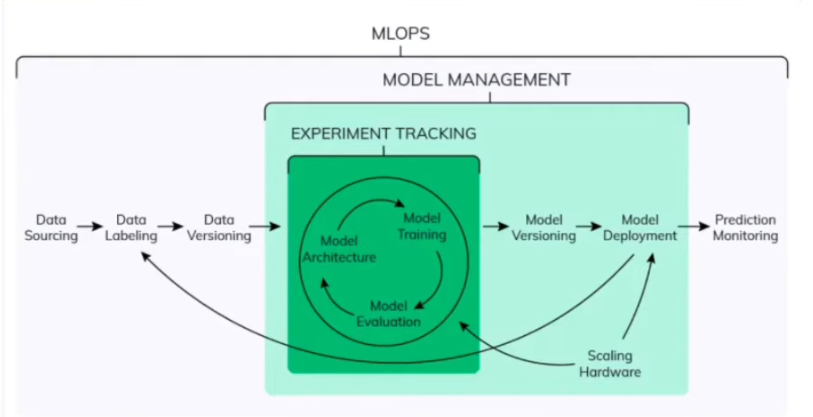


[Neptune ML experimentation blog](https://neptune.ai/blog/ml-experiment-tracking)

In [34]:
model2 = xgb.train(
    params = final_params,
    dtrain= train,
    num_boost_round= 5,
    evals= [(valid, 'validation')],
    early_stopping_rounds= 3)

mlflow.xgboost.log_model(model2, artifact_path= 'xgb_model')

2024/05/21 20:43:22 WARNING mlflow.xgboost: Failed to log dataset information to MLflow Tracking. Reason: Unable to allocate 233. GiB for an array with shape (2855951, 21910) and data type float32
/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:43:22] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:6.06344
[1]	validation-rmse:5.01960
[2]	validation-rmse:4.79520
[3]	validation-rmse:4.74219
[4]	validation-rmse:4.72329


2024/05/21 20:43:43 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/05/21 20:43:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:43:43] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."
/home/wsl/mlops-zoomcamp/mlz_env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:43:44] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [35]:
dv_path = 'models/preprocessor.b'
with open(dv_path , 'wb') as fout:
    pickle.dump(dv, fout)
    
mlflow.log_artifact(local_path= dv_path, artifact_path= "xgb_model")